# Transit method detection of four exoplanets orbiting solar mass star and investigation into their respective habitability 

Student number: 23746

### Abstract: 

Habitability of an exoplanet, a planet orbiting a star other than our sun, refers to its potential to host life.  This report uses the lightcurve of a solar mass star to detect three exoplanets, using the transit method.  Planets were found with a period of $26.6845$, $13.0249$ and $31.9961$ Earth days, using a periodogram and folding of the lightcurve.  Using a simple function to model the planet transit, the corresponding planet radii was calculated from the dip in flux.  Planet’s with radius $3.348±0.063R_{earth}$ , $3.056±0.057 R_{earth}$ and  $4.128±0.078 R_{earth}$ were detected.  Comparing the planets to the exoplanet population, found on the NASA archive it is confirmed that the planets are not outliers. Whether or not a planet is terrestrial, or a gas giant is a key factor in habitability, hence planet density is investigated. A simple approach to model the boundary of the habitable zones, an area where liquid water would theoretically exist on the planet surface, is then used to determine if any of the detected planets fall within this zone and the other considerations and factors that affect habitability that require investigation are discussed. 

#### Imports: give all your imports in a box here. Any custom code you have stored in a .py file needs to be submitted with your coursework. You can freely use all code provided to you as part of this course. If you use code not encountered in the course, give a link to the online repo.

In [1]:
import numpy
from astropy.io import fits #used to open fits files in which data are stored
import pylab #plotting
import glob
import numpy as np 
import pandas as pd
import seaborn as sns
import scipy.signal
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import medfilt
from scipy.signal import lombscargle 
import scipy.optimize

from scipy import interpolate
from scipy.optimize import curve_fit
from CompSample import conflevels, density_scatter

from functions import import_and_flatten_lightcurve
from functions import fold_lightcurve
from functions import planet_radius
from functions import semi_major_axis
from functions import planet_temperature
from functions import flux_eff

### 1. Introduction:

The search for evidence of life beyond Earth is a fascinating, expanding and fast-moving area of astronomy.  The first planet detected outside our solar system was only discovered in 1995, with thousands more planets being discovered since.  With such a diverse and growing range of planetary systems, more recently, planets that may resemble our own have been found, sparking enthusiasm in the search for habitable exoplanets.  Despite this with current technology no satellites can observe these exoplanets, therefore scientists have to infer from astronomical observations. 

The most common methods of exoplanet detection are the radial velocity and transit methods.  The former detects the minuscule motion of a star using high-resolution spectroscopy, the doppler shift in the light indicates the star moving towards or away from an observer.  This movement arises from the planet and star orbiting a common centre of mass and confirms a planet in orbit.  The detection probability reduces for lower reduced masses and increased semi-major axis; therefore, the method is biased to larger planets on shorter orbits.  One difficulty can be due to false planet detections, as star spots decrease emissivity of a star and can alter the centre of mass. 

In this paper, exoplanets will be detected in orbit around a solar mass star the transit method. The launch of the dedicated transit-detection space telescope Kepler in 2009 means this method has detected the majority of exoplanets.  [2 pg. 4].  The method is simple, exoplanets orbiting a star periodically block some of the light from the star, this dip in a star’s observed luminosity every period can be recorded, using the equation: 
∆F/F=  〖R_planet〗^2/〖R_star〗^2 

The main limitation of the transit method is that planets can only be detected where the orbit is aligned with our line of sight.  The further the planet is from the star, the smaller the misalignment needed to result in a missed transit; hence the transit method is biased towards planets with shorter periods, closer to their host star. 

Earth is the only known planet hosting life, hence terrestrial, ‘earth-like’ planets within the habitable zone are the most likely to be habitable.   The habitable zone is defined as the region where a rocky planet can maintain surface liquid water and is useful to highlight planets with the highest probability of hosting life. Modelling of the planet’s atmospheric composition is also important as it greatly affects the planet’s climate and temperature, however due to limited data this will not be explored in detail.   

In this paper the detected planet’s properties will be compared to the wider confirmed exoplanet population, using the NASA archive as well as to earth.  We will need to determine if the planet is terrestrial and whether is sits within the habitable zone, the first two main steps in unveiling whether the planet is capable of hosting life. 

### 2. Results - Modelling of Kepler lightcurve
The first stage in detecting exoplanets is to clean and flatten the lightcurve.  The lightcurve refers to observations of the light from a star, in this case hosting multiple planets, over a long period of time.  Outliers are defined as … and removed.  The lightcurve is flattened, diving through by a median filter with kernel size 101, to remove and variations in light arising from (???). The full normalised lightcurve can be seen in Figure 1. 

In [44]:
#the function below cleans the data and flattens the lightcurve using a median filter with kernal size of 101 days
alldata = import_and_flatten_lightcurve()

<ErrorbarContainer object of 3 artists>

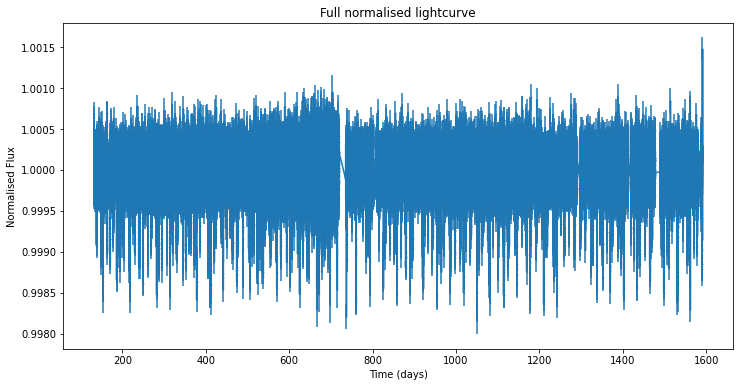

In [45]:
#plotting the normalised lightcurve
pylab.figure(figsize=(12,6))
pylab.xlabel('Time (days)')
pylab.ylabel('Normalised Flux')
pylab.title('Full normalised lightcurve')
pylab.errorbar(alldata['time'], alldata['new flux'],alldata['error'], ls=None, marker='o', ms=0.5)

Figure 1: <i>Normalised flux against time is shown across the full lightcurve with error bars.</i>

Next, the Lomb-Scargle Periodogram is used to identify periodicity as shown in Figure 2. 
The Lomb-Scargle Power refers to an estimate of the Fourier power and is plotted as a function of frequency and then period.  The second Lomb-Scargle removes any peaks due to aliasing and allows clear peaks that repeated at every multiple of themselves to be determined.  NumPy masks are used to zoom into the peaks and then the function pd.idxmax() function was used to determine the exact period where the peak occurs.  The detected period can then be confirmed and refined using a folded lightcurve.  

In [34]:
freqs = np.linspace(1/670., (1/0.02043), 10000)
lomb = scipy.signal.lombscargle(alldata['time'], alldata['new flux'], freqs, precenter = True)

freqs2 = np.linspace(1/48.9461, (1/0.004895), 10000)
lomb2 = scipy.signal.lombscargle(freqs, lomb, freqs2, precenter = True)

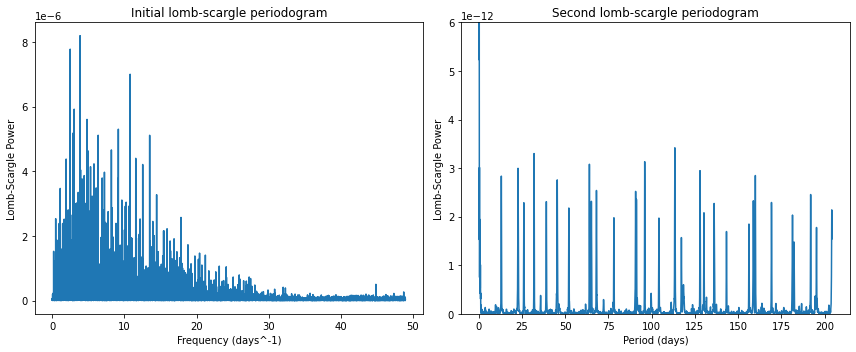

In [35]:
pylab.figure(figsize=(12,5))
pylab.subplot(1,2,1, ylabel='Lomb-Scargle Power', xlabel='Frequency (days^-1)', title='Initial lomb-scargle periodogram')
pylab.plot(freqs,lomb)

pylab.subplot(1,2,2, ylabel='Lomb-Scargle Power', xlabel='Period (days)',ylim=(0,0.6e-11),title='Second lomb-scargle periodogram')
pylab.plot(freqs2,lomb2)
plt.tight_layout()

Figure 2: <i>Lomb-Scargle periodogram on lightcurve and then second periodogram on the first periodogram. Peaks on the second periodogram correspond to periods of planets in orbit around the star.</i>

In [6]:
#simple function to define box model for plant's transit 
def lightcurve_model(t, base_flux, transit_flux):
    "Input: array of time values, numerical guess for base flux and transit flux"
    "Returns: box step model for the transit given the start and end transit time (which differs for each planet) "
    model=np.ones(len(t))
    
    for i in range(0,len(t)):
        if (t[i] > t_start) and (t[i] < t_end):
            model[i] = transit_flux
        else: 
            model[i] = base_flux
    return model 

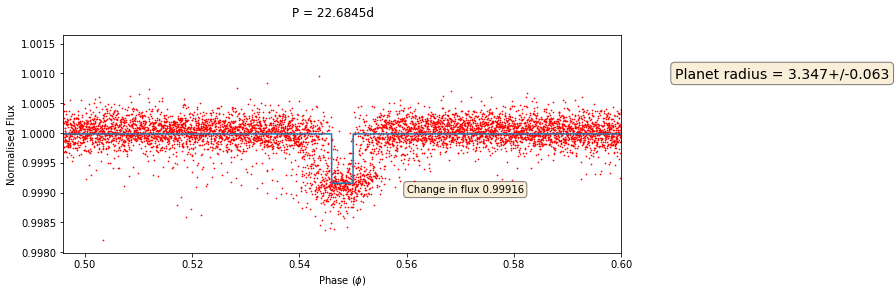

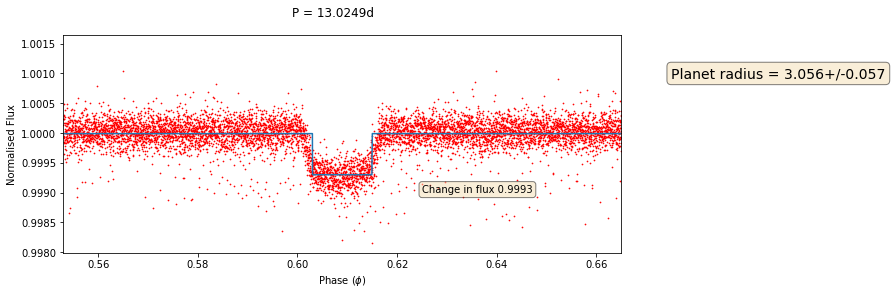

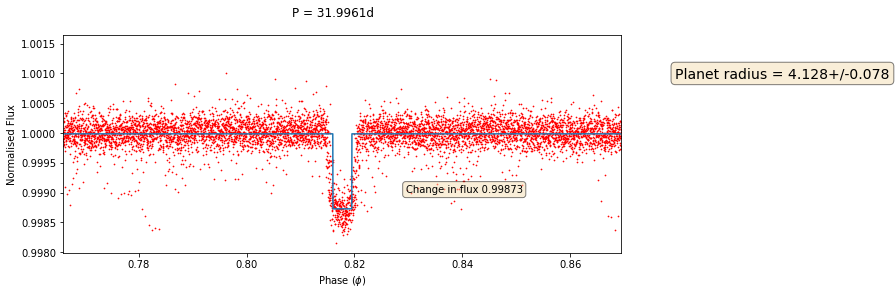

In [33]:
#detected periods from periodogram peaks 
period = [22.6845, 13.0249, 31.9961]
for p in period:
    if p==22.6845:
        t_start = 0.546
        t_end = 0.55
    elif p == 13.0249:
        t_start = 0.603
        t_end = 0.615
    else: 
        t_start = 0.816
        t_end = 0.8195
        
    #applying the fold_lightcurve function 
    fold_data = fold_lightcurve('test_fold.csv', p)
    
    #create new arrays using the folded data 
    x=np.array(fold_data['Phase'])
    y=np.array(fold_data['mag'])
    err=np.array(fold_data['error'])

    #using SciPy curve fit function to determine best fit parameters by reducing chi squared 
    popt, pcov = curve_fit(lightcurve_model,x, y, sigma=err,absolute_sigma=True, p0=[1, 0.999])
    
    #using planet_radius function to calculate radius of planet 
    radius = planet_radius(popt, pcov)[0]
    radius_err = planet_radius(popt, pcov)[1]
    
    #plotting and formatting
    pylab.figure(figsize=(10,4))
    pylab.xlim(t_start-0.05, t_end+0.05)
    pylab.plot(x, y, c='r', marker='o',ls='None', ms=0.7)
    model_y = lightcurve_model(x, popt[0], popt[1])
    pylab.plot(x, model_y)
    
    #adding axis labels, annotations and titles to each graph 
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    labeltext = 'Change in flux ' +str(np.around(popt[1], decimals=5))
    plt.text(t_end+0.01, 0.998+0.001, labeltext, horizontalalignment='left', bbox=props)
    radiustext = 'Planet radius = '+str(np.around(radius, decimals=3)) +'+/-' +str(np.around(radius_err, decimals=3))
    plt.text(t_end+0.06, 1.001, radiustext, bbox=props, fontsize =14, verticalalignment='center', horizontalalignment='left')
    titletext = 'P = ' + str(np.around(p, decimals=4)) + 'd'
    plt.suptitle(titletext)
    pylab.xlabel('Phase ($\phi$)')
    pylab.ylabel('Normalised Flux')

Figure 3: <i>Folded lightcurve at period (P) as shown in title. Decrease in flux shows a clear transit and confirms planet present at this period. Transit model is plotted in blue for comparison against data.  Error bars excluded for clarity. </i>

The figure above shows the folded lightcurve plotted as a function of phase rather than time.  It clearly shows a planet in transit due to the dip in flux.  A simple box model is used to determine the change in flux.  The model is optimised using the curve_fit() function from the SciPy toolbox to give a value for the change in flux shown. This minimizes chi squared to output the optimal values for the base flux and transit flux. 

The planet's radius is calculated using the following equation:<br> 
$\frac{\delta F}{F} = \frac{(R_{planet})^2}{R_*^2} $
* The relative drop in flux is related to the area of the planet divided by the area of the star.<br>
(The planet radius function can be found in the supporting functions.py file)

<b>Deriving physical properties for the planet.</b> <br>
First the known infomation on the three planets and the parent star will be collated into a dataframe. Then using these known properties, additional properties will be derived and added to the dataframe. 

In [9]:
#constants
mass_j = 1.9e27 #mass of jupiter (kg)
mass_e = 5.972e24   #mass of earth (kg)
s_const = 5.67e-8   #Stefan-Boltzmann constant 
solar_radius = 6.96e8   #Solar radius 
solar_lum = 3.828e26   #Solar luminosity 


#given values 
mass_p = [0.023*(mass_j/mass_e), 0.009*(mass_j/mass_e), 0.025*(mass_j/mass_e)] #planet mass (Earth mass)
mass_p_err = [0.004*(mass_j/mass_e), 0.005*(mass_j/mass_e), 0.006*(mass_j/mass_e)]  #planet mass error (Earth mass)
planet_names = ['Planet 1', 'Planet 2', 'Planet 3']
#period_p = [22.6845, 13.0249, 31.9961]  #planet period in days 

#planet properties 
planet_info = pd.DataFrame({'planet': planet_names,'period':period, 'mass': mass_p, 'mass err':mass_p_err})

#stellar properties in comparison to sun (solar radii and solar mass units)
stellar_info = pd.DataFrame({'radius':1.065, 'radius err':0.02, 'mass':0.961, 'mass err':0.025, 'temp':5657}, index=[0])

Calculation of the luminosity of the star in solar luminosity units, using the equation: 
$ L = 4 \pi R^2 \sigma\ T^4 $

In [10]:
stellar_info['luminosity'] = (4*np.pi * (stellar_info['radius'][0]*solar_radius)**2 * s_const * stellar_info['temp'][0]**4)/solar_lum
stellar_info['luminosity err'] = ((stellar_info['luminosity'][0]*2*stellar_info['radius err'][0])/stellar_info['radius'][0])
stellar_info

,radius,radius err,mass,mass err,temp,luminosity,luminosity err
0,1.065,0.02,0.961,0.025,5657,1.04733,0.039336


Table 1: <i>Table showing the given and calculated stellar properties all in solar units eg. solar radii, solar mass and solar luminosity. </i>

In [11]:
#Inputting the calculated radius and associated error for each planet into a dataframe:
radius_p = [3.3475e+00,3.0556e+00,4.1278e+00]  #in Earth radii 
radius_p_err = [6.2864e-02,5.7383e-02,7.7517e-02]  #in Earth radii 
planet_info['radius'] = radius_p
planet_info['radius err'] = radius_p_err

<b>Semi-major axis (a) of the planet is calculated using a re-arranged version of Kepler's third law: </b> <br>
 $a^3 = \frac{G M_{*} P^2}{4\pi^2} $   <br>      
* P = Period, G = Gravitational constant and M = Mass of star <br>
* Assumptions:  Mass of star >> mass of planet, hence mass of planet negligible

<b>Planet temperature can be calculated using the following equation: </b> <br>
$ T = (\frac{(1-\alpha)L_{*}}{16 \pi \sigma a ^2})^{\frac{1}{4}}$ <br>
* $ \alpha  $ = Albedo, $L_*$ = Stellar Luminosity, a = Semi-major-axis
* Assumptions: There is no albedo afffect on the planet, hence $\alpha=0$; There is no atmosphere altering temperature due to the greenhouse effect'

<b>Flux on the surface of the planet can be calculated by combining the following equations: </b> <br>
$ F = \frac{L_*}{4\pi d^2}$ and
$ F_{earth} = \frac{L_{sun}}{4\pi }$ (where d is the distance to the star in AU)  hence <br>
$ Flux = \frac{F}{F_{earth}} = \frac{L_*/L_{sun}}{d^2}$
* $ L_{sun}$ = Solar luminosity, Flux = Flux in Earth flux units, d = distance from star to planet in AU
* Assumptions: The planets orbit is circular

(Code for functions can be viewed in the supporting 'functions' py file)

In [12]:
planet_info['semi_major'], planet_info['semi_major_err'] = semi_major_axis(planet_info['period'])  #in AU 
planet_info['temp'], planet_info['temp_err'] = planet_temperature(planet_info['semi_major'], planet_info['semi_major_err'])  #in Kelvin
planet_info['flux'], planet_info['flux_err'] = flux_eff(planet_info['semi_major'], planet_info['semi_major_err'])   #in Earth flux units

In [13]:
planet_info.set_index('planet')

,period,mass,mass err,radius,radius err,semi_major,semi_major_err,temp,temp_err,flux,flux_err
planet,,,,,,,,,,,
Planet 1,22.6845,7.317482,1.272605,3.3475,0.062864,0.154741,0.001073,715.784479,2.482777,43.739446,0.040039
Planet 2,13.0249,2.863362,1.590757,3.0556,0.057383,0.106898,0.000742,861.193113,2.987142,91.652933,0.040039
Planet 3,31.9961,7.953784,1.908908,4.1278,0.077517,0.194618,0.001350,638.253197,2.213851,27.651339,0.040039


Table 2:<i> Showing the given and calculated planetary properties for each detected planet.  Units: period in days, mass in $M_{earth}$, radius in $R_{earth}$, semi-major axis in AU, temperature in Kelvin and flux in $F_{earth}$

### 3. Discussion


In [43]:
#importing data from the NASA archive online, available at https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/
NASA_data = pd.read_csv('NASA archive data 2.csv', delimiter=',')

#### Comparing detected planets to wider planet population

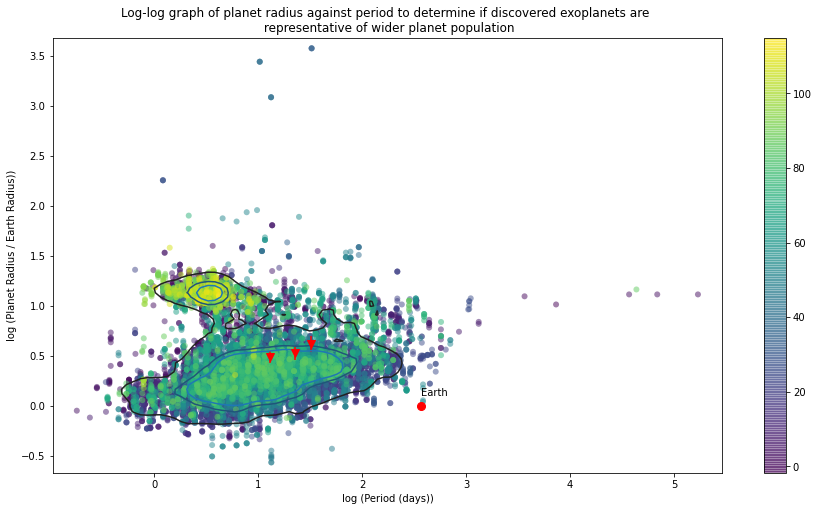

In [15]:
#creating new dataset with data for kde plot
data_kde = pd.DataFrame({'log period': np.log10(NASA_data['pl_orbper']), 'log radius':np.log10(NASA_data['pl_rade'])})
data_kde.dropna(inplace=True)

pylab.figure(figsize=(15,8))

#set the colours of the markers according to density
dencol=density_scatter(np.array(data_kde['log period']), np.array(data_kde['log radius']), bins = [100,100])
#sets the number of bins and where the contour levels lie
levels = conflevels(data_kde['log period'],data_kde['log radius'],nbins=200,confints=[0.997,0.8,0.68])

#scatter plot of NASA exoplanet data points 
pylab.scatter(data_kde['log period'], data_kde['log radius'], c=dencol, cmap='viridis', linewidth=0, alpha=0.5)

#planet data points 
pylab.errorbar(np.log10(planet_info['period']), np.log10(planet_info['radius']), (planet_info['radius err']), ls='None', marker='v', c='r', ms=8)
#earth data point for comparison 
pylab.plot(np.log10(365), 0, ms=8, c='r', marker='o')
pylab.text(np.log10(365), 0.1, "Earth")

#kde confidece levels plot
ax = sns.kdeplot(data_kde['log period'],data_kde['log radius'], n_levels=levels)
ax.set(xlabel ='log (Period (days))', ylabel = 'log (Planet Radius / Earth Radius))', title='Log-log graph of planet radius against period to determine if discovered exoplanets are \n representative of wider planet population')
plt.colorbar()

Figure 4: <i>Plot of Log (Planet Radius in Earth Radii) against Log (Period (days)) showing the relationship between radius and period.  The figure demonstrates some key selection effects of the most common exoplanet detection methods, favouring planets on shorter orbits and with larger radii or masses. Earth is shown for comparison alongside the three detected exoplanets with triangle markers.  The colour corresponds to the density of planets found at that point in bivariate space, whilst the contour plots contain 99.7%, 80% and 68% of the datapoints respectively. </i>

Over 99.7% of the detected exoplanets have an orbital period less than 1 year.  This is most likely due to selection effects.  For the transit method, planets on shorter orbits can be observed for multiple periods, hence they are easier to confirm and are more likely to be aligned with our line of sight.  In addition, 

The outermost contour line contains 99.7% of the data points.  As all three planets lie within this contour, we can conclude none are outliers.  In addition, if we assume that the data distribution of planet’s radius and period are normal, then 68% of data points like with one standard deviation of the mean. Hence, we can assume that planet 1 and planet 2 likely lie within one standard distribution of the mean for both radius and period. 

The top left area of the graph is interesting, showing large group of planets with a short period (on very close orbits) and large radius. This corresponds to what is frequently known as ‘hot Jupiters’, which are interesting as they resemble no planet in our solar system.  They are planets that have similar physical properties to Jupiter but with extremely short orbits (roughly 0.015 – 0.05 AU or a few hours to days).  Close proximity to the stars results in high surface temperatures.  It cannot be assumed however, they these hot Jupiters make up a large proportion of the exoplanet population due to selection effects.  Hot Jupiters are the easiest extrasolar planets to detect via the radial velocity method, due to the large oscillations they induce on the star as they have a large mass and are on very close orbits.  It is now known, systems housing hot Jupiters are rare, consisting of only 1% of planetary systems, highlighting the importance of understanding and accounting for selection effects. 

#### Relationship between planet radius and mass.  Are any of the detected planet's terrestial? 

In [16]:
def density_func(density, mass): 
    "input: density in kg/m^3 eg. desnity of water = 997"
    "returns: radius as function of mass in units of earth radius"
    "assumptions: assuming constant density and mass and radius are proportional"
    
    earth_radius = 6.371e6
    earth_mass = 5.972e24
    
    r = (3/(4 * np.pi * density))**(1/3) * ((mass*earth_mass)**(1/3))
    return r/earth_radius

mass = np.array(NASA_data['pl_masse'])
sorted_mass = np.sort(mass)

water = density_func(997, sorted_mass)
air = density_func(1.225, sorted_mass)
rock = density_func(2960, sorted_mass)

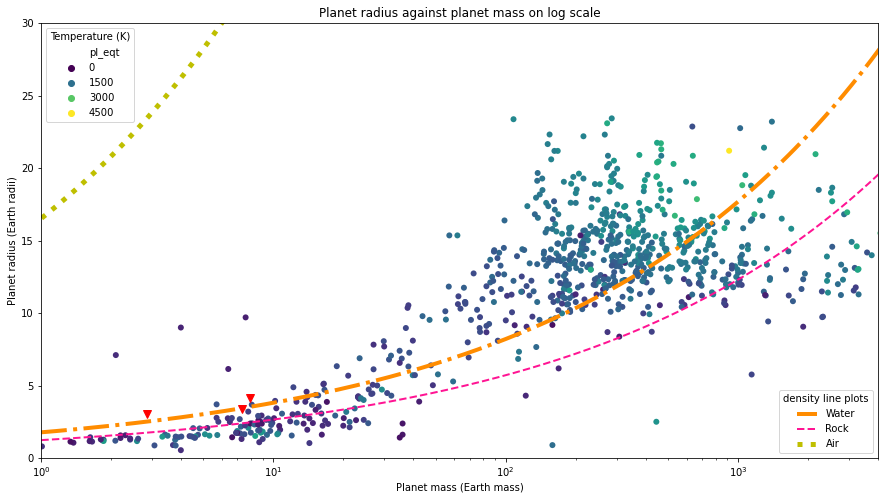

In [17]:
pylab.figure(figsize=(15,8))
pylab.ylim(0,30)
pylab.xlim(1, 4000)

#plotting detected planets
pylab.errorbar((planet_info['mass']), (planet_info['radius']), planet_info['radius err'], ls='None', marker='v', c='r', ms=8)

#plotting NASA archive planets 
ax = sns.scatterplot(x=(NASA_data['pl_masse']), y=(NASA_data['pl_rade']), marker='o', hue=NASA_data['pl_eqt'],linewidth=0, palette='viridis')
ax.set(xlabel='Planet mass (Earth mass)', ylabel='Planet radius (Earth radii)', title='Planet radius against planet mass on log scale', xscale='log')
legend1 = ax.legend(title='Temperature (K)', loc=2)

#plotting line plots for different materials 
water_plot, = ax.plot(sorted_mass, water, label='water', c='darkorange', ls='-.', lw=4)
rock_plot, = ax.plot(sorted_mass, rock, label='rock', c='deeppink', ls='--', lw=2)
air_plot, = ax.plot(sorted_mass, air, label='air', c='y', ls=':', lw=5)
legend2 = ax.legend([water_plot, rock_plot, air_plot],['Water', 'Rock', 'Air'], title='density line plots', loc=4)
ax.add_artist(legend1)

Figure 5: <i>Plot of planet radius (in Earth radii) as a function of Planet mass in Earth masses and planet equilibrium temperature, provides insight into planet density.  The approximate densities of rock and water are plotted to compare the detected planet densities to physical observables. </i>

Where the planet mass is less than $100  R_{earth}$ the relationship between radius and mass appears linear.  Using SciPy's curve fit function to create an optimised linear fit, the fit looks appropriate, residuals show no systematic error. The reduced chi squared value is 218, indiciating the true uncertainty in the radius is likely greater than the uncertainty used.  Where the planet mass is greater than $100 R_{earth}$, this fit begins to fail, reduced chi squared increases to 5000.  At higher mass values the radius remains constant as mass increaes, implying increased density. There appears to be a weak positive correlation between the temperature of the planet and the radius of the planet at these greater masses.

Planets tend to be considered terrestrial or rocky, when the radius is less than two earth radii, or the mass is less than 10 Earth masses. This makes sense as the lower mass planets have greater densities, and lower mass planets are more likely to form through accretion, creating terrestial planets as opposed to gravitational collapse.

All three planets have mass less than 10 Earth masses; however, the radius of the detected planets vary between 3 to 4 Earth radii.  The density line plots shown allow some comparison between common physical entities.   Planet 1 appears to be most dense, with a density somewhere between water and rock (magnesium sulphite) and is possibly terrestial, however it is unlikely planet 2 or 3 can be considered terrestial as the density is less than the density of water.   



#### Do the detected planets lie within the habitable zone? 

In [18]:
def HZ_zone(): 
    stellar_temp = np.linspace(3000,6000,1000)
    T = stellar_temp - 5780 

    #INNER EDGE dented with i 
    S_suni = 1.7665
    ai = 1.3351e-4
    bi = 3.1515e-9
    ci = -3.3488e-12

    #OUTER EDGE denoted with o 
    S_suno = 0.324
    ao = 5.3221e-5
    bo = 1.4288e-9
    co = -1.1049e-12


    S_effi = S_suni + (ai*T) + (bi*(T**2)) + (ci*(T **2))
    S_effo = S_suno + (ao*T) + (bo*(T**2)) + (co*(T **2))
    
    pylab.plot(S_effi, stellar_temp)
    pylab.plot(S_effo, stellar_temp)
    plt.fill_betweenx(stellar_temp, S_effi, S_effo, color='honeydew')

In [19]:
#effective flux in earth flux units
Earth = 1
#1/d^2 using d as semi_major axis in AU units
Venus = 1/(0.723**2)
Mars = 1/(1.524**2)
solar_temp = 5780 

In [20]:
#calculates effective flux on planet's surface in units of earth flux (converts luminosity in log(solar) units to solar units )
NASA_data['effective flux'] = (10**NASA_data['st_lum']) / (NASA_data['pl_orbsmax'])**2

Text(0.33055641666838886, 5800, 'Mars')

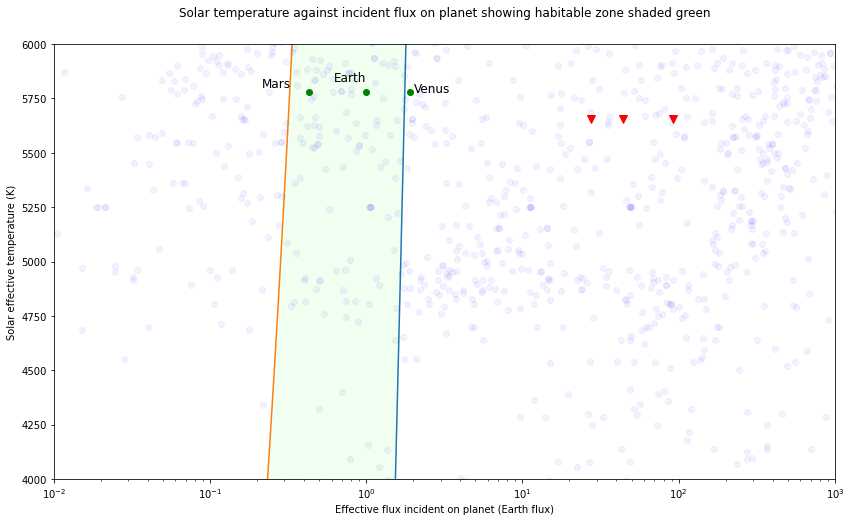

In [41]:
#ax = pylab.plot(planet_info['flux'], [stellar_info['temp'],stellar_info['temp'],stellar_info['temp']], ls='None', marker='v', c='r', ms=8)
pylab.figure(figsize=(14,8))
ax = pylab.errorbar(planet_info['flux'], [stellar_info['temp'],stellar_info['temp'],stellar_info['temp']], xerr=planet_info['flux_err'],ls='None', marker='v', c='r', ms=8)
plt.xlabel('Effective flux incident on planet (Earth flux)')
plt.ylabel('Solar effective temperature (K)')
plt.title('Solar temperature against incident flux on planet showing habitable zone shaded green', y=1.05)
pylab.xscale('log')

HZ_zone()

pylab.plot(NASA_data['effective flux'], NASA_data['st_teff'], ls='None', marker='o', c='b', alpha=0.05)
pylab.ylim(4000,6000)
pylab.xlim(0.01,1000)

pylab.plot([Earth, Mars, Venus], [solar_temp, solar_temp, solar_temp], ls='None', marker='o', c='g')
plt.text(Venus+0.1, solar_temp, "Venus", horizontalalignment='left', fontsize=12)
plt.text(Earth, solar_temp+50, "Earth", horizontalalignment='right',fontsize=12)
plt.text(Mars-0.1, solar_temp+20, "Mars", horizontalalignment='right',fontsize=12)

Figure 6:  <i>Stellar effective temperature is plotted against effective flux on the planet’s surface as a unit of Earth flux. The function HZ_zone() plots the limits of the habitable zone using equation…. A number of planets from the solar system are included for reference. The NASA archive conformed exoplanets are plotting in the background also for reference. </i>

The following equation is used to determine the edges of the habitable zone $ S_{eff} = S_{sun} + a T_* + b T_* ^2 + c T_* ^3 $ [3 pg. 17] 

From the figure it can be seen that none of the detected planets lie within the habitable zone.  They are beyond the hotter edge of the habitable zone – indicated that there semi major axis is too short, and they received flux would lead to very high temperatures and inhabitable conditions. 

An important follow up observation would be the detection of an atmosphere; a required condition for a habitable exoplanet.  An atmosphere is defined as an envelope of gas surrounding a planet, that remains due to gravity.  Water remains liquid within a relatively narrow range of temperatures and pressures, and an atmosphere is crucial in keeping the temperature and pressure on the planet’s surface stable to meet this condition. An atmosphere also traps the heat and would be required for a planet on the outer edge of the habitable zone.  Transmission spectroscopy will need to be carried out at a range of wavelengths.  Peaks in the spectrum at particular wavelengths can be used to identify specific molecules.  One interesting biosignature to observe within an atmosphere, is the simultaneous presence of O2 and CH4, as this is strong evidence of life as they are predominantly produced biologically.   [3 pg. 28]. [2 pg. 9]  The model for the habitable zone relies on flux as the main parameter, however it is worth noting eccentricity, obliquity (tilt of the planet’s rotational axis relative to the star-planet plane) and planet rotation (controls length of one day) all contribute to the amount of stellar radiation received by the planet.  Another observation could be determining the obliquity and rotation rate for a terrestrial planet, which requires time-dependant mapping using direct imaging observations. [2 pg.11].  Finally, the habitability of a planet also depends upon the host star’s characteristics, including stellar spectral energy distribution, stellar winds, X-ray/UV ray emissions etc. so this would need to be further investigated for a potential habitable planet.  [2] 

### 4. Summary

$\bullet$ 

### References:

Give all references here. Use Astronomy style references, e.g.
- Miller & Jones, 2018, ApJ, 00, 000
- Smith et al. 2019, MNRAS, 00, 000
- Willow 1972, AJ, 00, 000

And cite these in the text as "Miller & Jones (2018) showed that all exoplanets are made of cheese, however, Smith et al. (2019) showed Trappist1b is made of chocolate, as previously suggested in the literature (Willow 1972)." 